# Parcial 2 Series de tiempo


Considere la serie de tiempo que le correspondió. Asuma que el primer 75% de las observaciones son de entrenamiento, el siguiente 10% de validación y el restante 15% de prueba.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
#from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import sklearn
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df_expo = pd.read_excel('exportaciones.xlsx', sheet_name='exportaciones_fecha')
df_expo.head()

,Fecha,banano,flores,total_sector_agro,oro,esmeraldas,total_sector_minero,textil,quimicos,papel,cuero,alimentos,total_sector_industrial
0,1970-01-01,0.0,0.0,3.7,0.0,0.3,1.5,3.7,0.6,0.2,0.5,2.1,8.9
1,1970-02-01,0.0,0.0,4.6,0.0,0.3,1.7,4.5,0.8,0.3,0.6,2.6,10.8
2,1970-03-01,0.0,0.0,5.6,0.0,0.4,2.1,5.6,0.9,0.4,0.8,3.2,13.4
3,1970-04-01,0.0,0.0,4.3,0.0,0.3,1.7,4.4,0.7,0.3,0.6,2.5,10.5
4,1970-05-01,0.0,0.0,5.4,0.0,0.4,2.1,5.3,0.9,0.4,0.8,3.1,13.0


In [3]:
df_expo.columns # 12 series

Index(['Fecha', 'banano', 'flores', 'total_sector_agro', 'oro', 'esmeraldas',
       'total_sector_minero', 'textil', 'quimicos', 'papel', 'cuero ',
       'alimentos', 'total_sector_industrial'],
      dtype='object')

In [4]:
np.random.seed(22112022)
df_expo.columns[np.random.randint(1,13)]

'alimentos'

In [5]:
df_expo['Fecha']=pd.to_datetime(df_expo['Fecha'])
[df_expo.shape, min(df_expo['Fecha']), max(df_expo['Fecha'])]

[(631, 13), Timestamp('1970-01-01 00:00:00'), Timestamp('2022-07-01 00:00:00')]

## Serie de `alimentos`

1. Haga un análisis descriptivo de la serie de tiempo, e.d. realice todos los análisis correspondientes para detectar las posibles características que tiene presente la serie. Qué puede observar al respecto?

In [6]:
#remesas['Fecha']=remesas['Fecha'].dt.date - pd.offsets.MonthBegin()
alimentos=pd.Series(df_expo['alimentos'].values,df_expo['Fecha'], name='alimentos')
alimentos.index.freq='MS'
alimentos.head()

Fecha
1970-01-01    2.1
1970-02-01    2.6
1970-03-01    3.2
1970-04-01    2.5
1970-05-01    3.1
Freq: MS, Name: alimentos, dtype: float64

### Gráfico de la serie

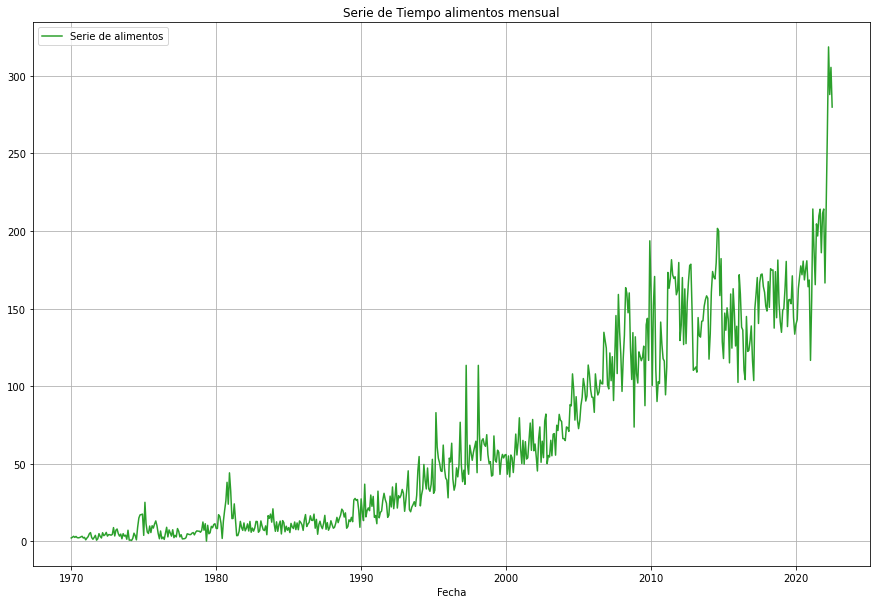

In [7]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(alimentos, color='tab:green', label='Serie de alimentos')
ax.set_xlabel('Fecha')
#ax.set_ylabel('Millones de USD')
ax.set_title('Serie de Tiempo alimentos mensual')
ax.grid(True)
ax.legend(loc='upper left');

Al observar el gráfico de la serie lo primero que se evidencia es una tendencia creciente (la cual no parece ser una función suave), también se observa que la serie presenta indicios de varianza marginal no constante (en algunos instantes de tiempo la variabilidad parece ser mayor), por otra parte se concluye que la serie no estacionaria en el sentido débil, debido a que la media difiere a lo largo del tiempo, finalmente la serie parece no tener ciclo estacional, sin embargo más abajo a través de la serie diferenciada se determinará si hay presencia de ciclos ocultos en la serie.

### Gráficos ACF y PACF

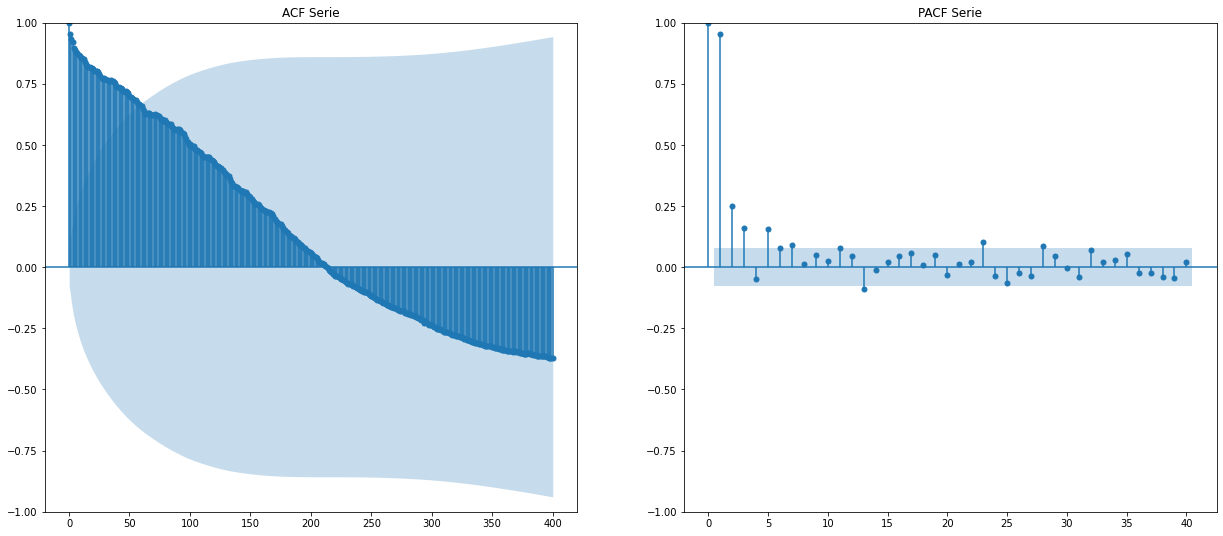

In [8]:
fig, ax = plt.subplots(1,2,figsize=(21,9))

plot_acf(alimentos, lags=400, ax=ax[0],title='ACF Serie')
plot_pacf(alimentos, lags=40, ax=ax[1],title='PACF Serie', method='ywmle')

plt.show()

### Descomposición de la serie

+ Descomposición usando promedios móviles

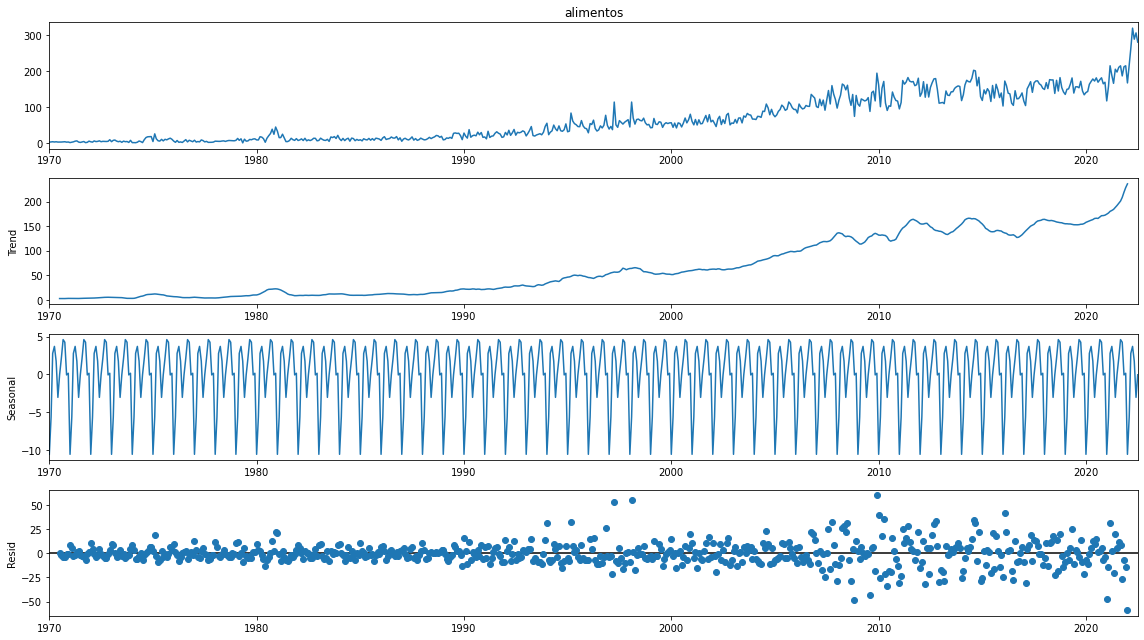

In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9
#%%R
#desrms=decompose(rms)
#plot(desrms)
rmsdeca = seasonal_decompose(alimentos, model = 'additive')
rmsdeca.plot()
plt.show()

+ Seasonal-Trend decomposition with LOESS (STL)

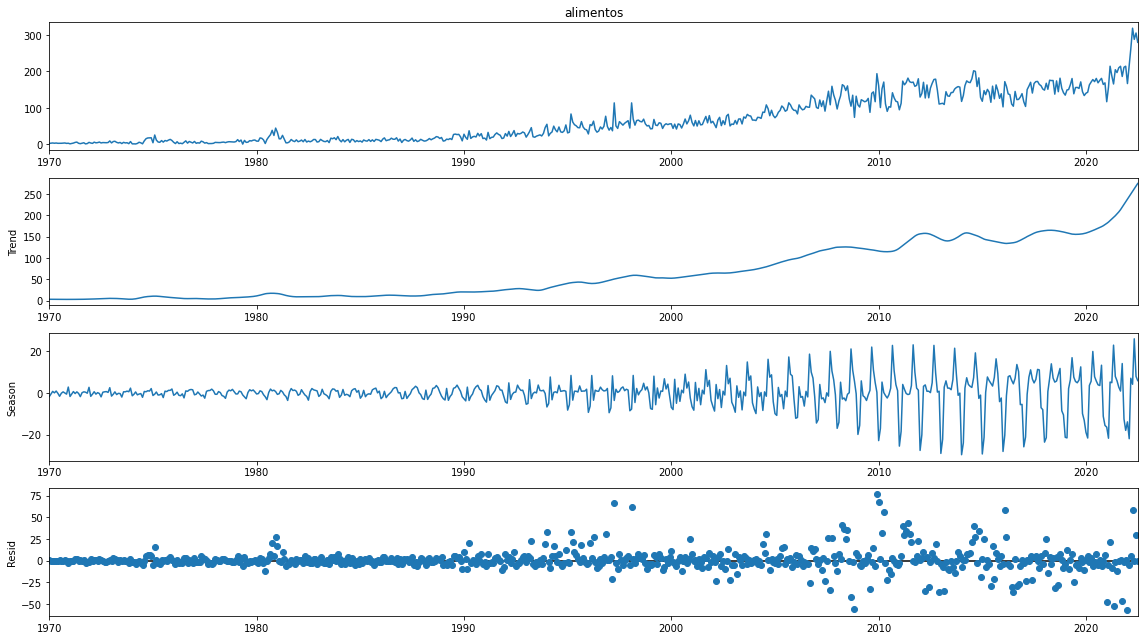

In [10]:
rms_stl = STL(alimentos,seasonal=13, # the seasonal smoother and can only take odd integer values greater than or equal to 7
              robust=True).fit()

rms_stl.plot()
plt.show()

### Gráfico de diagnóstico estacional

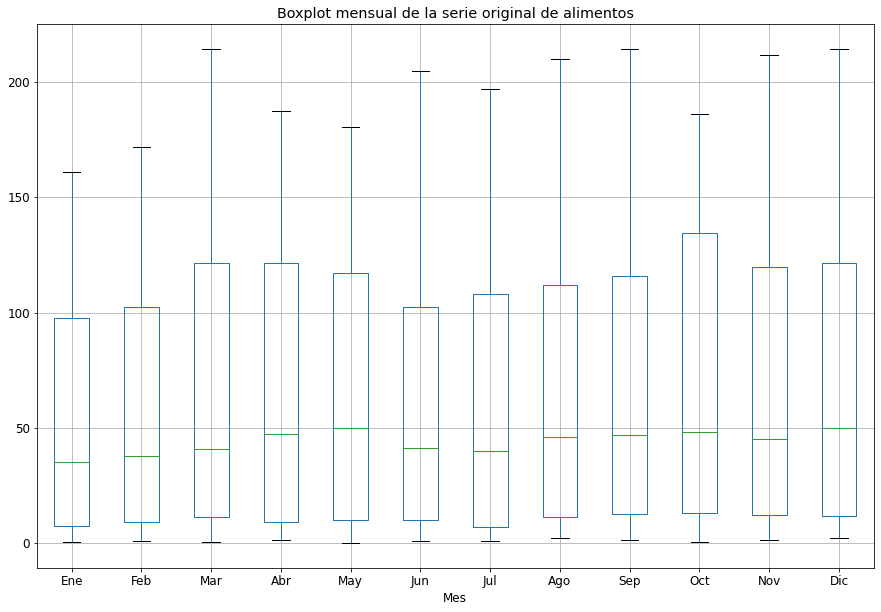

In [11]:
month=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
#rm=np.array(remesas2['BC_remesas'].iloc[0:264]).reshape(22,12)
rm=np.array(alimentos.iloc[0:624]).reshape(52,12)
rmd=pd.DataFrame(rm, columns=month)
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))
bpm=rmd.boxplot()
plt.title('Boxplot mensual de la serie original de alimentos') 
ax.set_xlabel('Mes')
#ax.set_ylabel('Millones de USD')
plt.show()

A partir de la gráfica de AFC se puede ver que no se va rapidamente a cero con lo cual concluimos que la serie no es estacionaria, por otra parte a partir de la descomposicón de promedios móviles vemos que la componente de tendencia parece deterministica (una función suave) , con lo cual concluimos que la serie presenta tendencia, por último a partir del gráfico de diagnóstico estacional concluimos que la serie no presenta ciclo estacional, debido a que no hay diferencias entre cada unos de los meses.

### Pruebas de raíz unitaria

En la prueba de Dickey Fuller al no rechazarse la hipótesis nula implica que existe raíz unitaria.

In [12]:
resultadoadf=adfuller(alimentos,regression="n",autolag=None, maxlag=12)####maxlag es importante
##Se debe elegir un lagmax grande y ver si el valor t de el último coeficiente de la variable
###Diferenciada es significativo(>1.6 en valor absoluto), si así lo es se lleva a cabo el test de Dickey Fuller
###Si no lo es, hay que reducir el rezago.
print('ADF Statistic: %f' % resultadoadf[0])
print('P-value: %f' % resultadoadf[1])
for key, value in resultadoadf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.954525
P-value: 0.999755
	1%: -2.569
	5%: -1.941
	10%: -1.616


**Prueba KPSS(Kwiatkowski-Phillips-Schmidt-Shin)**

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [13]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [14]:
kpss_test(alimentos) # rechaza la hipótesis que el proceso es estacionario

Results of KPSS Test:
Test Statistic            3.564793
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Eliminación de la tendencia

In [15]:
dif_alimentos=alimentos.diff(periods=1)[1:]
dif_alimentos.head()

Fecha
1970-02-01    0.5
1970-03-01    0.6
1970-04-01   -0.7
1970-05-01    0.6
1970-06-01   -0.8
Freq: MS, Name: alimentos, dtype: float64

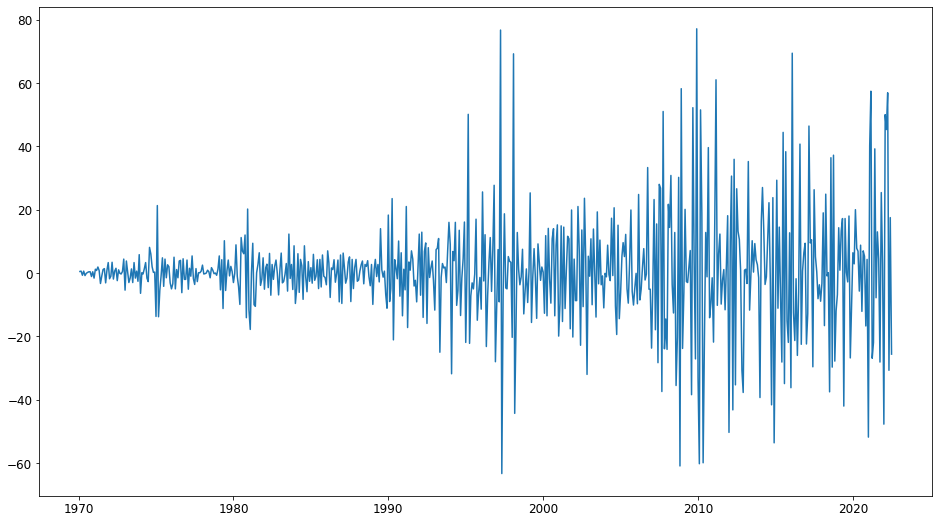

In [16]:
plt.plot(dif_alimentos)

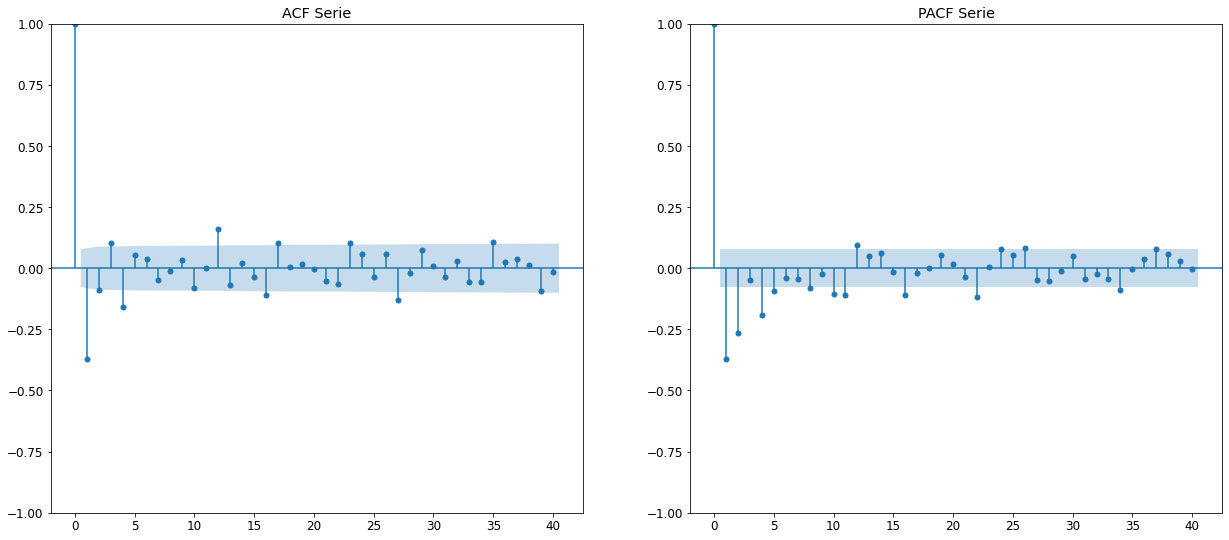

In [17]:
fig, ax = plt.subplots(1,2,figsize=(21,9))

plot_acf(dif_alimentos, lags=40, ax=ax[0],title='ACF Serie') # MA(12)
plot_pacf(dif_alimentos, lags=40, ax=ax[1],title='PACF Serie', method='ywmle') # AR(4)

plt.show()

### Análisis de Presencia de Estacionalidad

105
0.16666666666666666


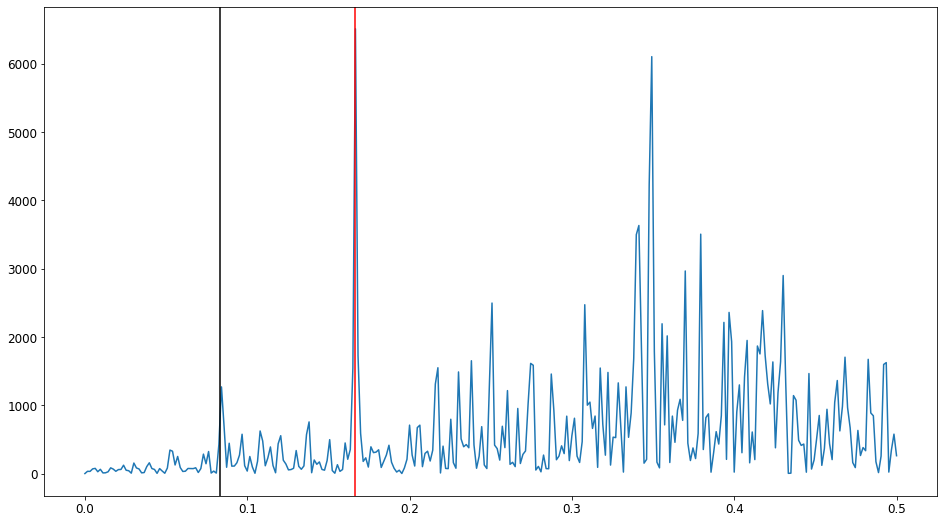

In [18]:
f, Pxx_den=sp.signal.periodogram(dif_alimentos)
plt.plot(f, Pxx_den)

max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value] # semestral
print(frecuencia_max)
plt.axvline(x=frecuencia_max,color='red')
plt.axvline(x=frecuencia_max/2,color='black')

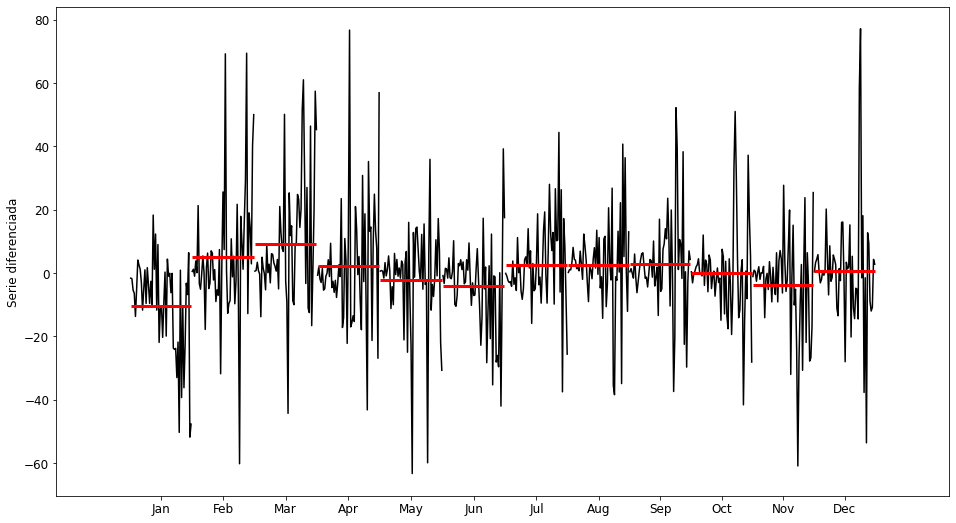

In [19]:
meses_logdiff_1=month_plot(dif_alimentos,ylabel='Serie diferenciada')

## la serie de tiempo requiere de una transformación del tipo Box-Cox?

Transformación Box-Cox 
$$f_{\lambda}(u_{t})= \left \{ \begin{array}{lc} \lambda^{-1}(u^{\lambda}_{t}-1)&  \lambda>0, u_{t} \geq 0 \\             \ln(u_{t}) & u_{t}>0, \lambda=0. \end{array} \right. $$ 

In [20]:
###Chequear si hay necesidad de estabilizar varianza
sertrans,lambdaest,intlambda=sp.stats.boxcox(alimentos,alpha=0.05)
print(lambdaest)  ###Valor de lambda
print(intlambda)  ###Intervalo donde posiblemente éste lambda

0.219753400509179
(0.1591275073533041, 0.2818679667943308)


La serie requiere una transformación Box-Cox con $\lambda = 0.21975$.

Text(0.5, 1.0, 'Serie de alimentos Original')

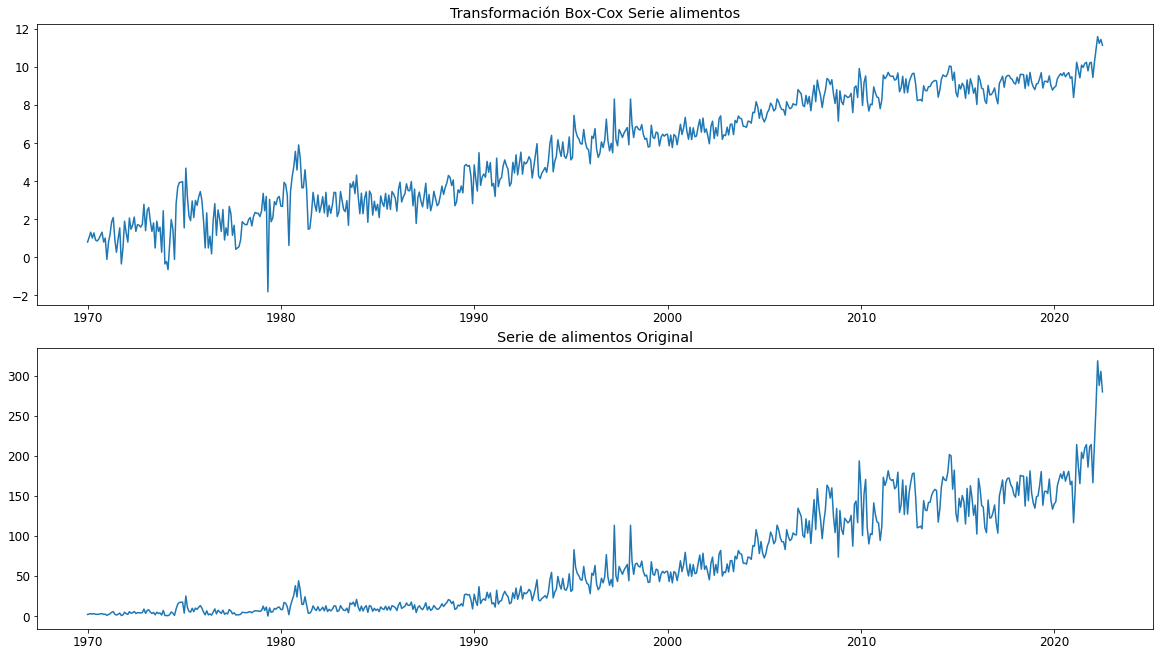

In [21]:
bcAlimentos=sp.stats.boxcox(alimentos,lmbda=lambdaest)

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,constrained_layout=True)
ax1.plot(bcAlimentos)
ax1.set_title('Transformación Box-Cox Serie alimentos')
ax2.plot(alimentos)
ax2.set_title('Serie de alimentos Original')

In [22]:
print(alimentos[-5:])
print(sp.special.inv_boxcox(bcAlimentos, lambdaest)[-5:])

Fecha
2022-03-01    261.8
2022-04-01    318.7
2022-05-01    288.0
2022-06-01    305.5
2022-07-01    279.9
Freq: MS, Name: alimentos, dtype: float64
Fecha
2022-03-01    261.8
2022-04-01    318.7
2022-05-01    288.0
2022-06-01    305.5
2022-07-01    279.9
Freq: MS, Name: alimentos, dtype: float64


## Ajuste 3 modelos para la serie de tiempo indicada

No olvidar usar el conjunto de validación para identificar los hiperparámetros, unir el conjunto de entrenamiento y validación como un sólo conjunto de entrenamiento.

Observación: En los modelos de árboles o redes neuronales, indicar las características o variables explicativas del modelo y cómo fueron seleccionadas.

### Árboles (Random Forest o XGBoosting)

En el caso de un modelo de árboles de decisión, indicar qué profundidad debe tener el árbol. 

In [23]:
dif_alimentos=bcAlimentos.diff(periods=1)[1:]
dif_alimentos.head()

Fecha
1970-02-01    0.257388
1970-03-01    0.262088
1970-04-01   -0.310265
1970-05-01    0.269412
1970-06-01   -0.370465
Freq: MS, Name: alimentos, dtype: float64

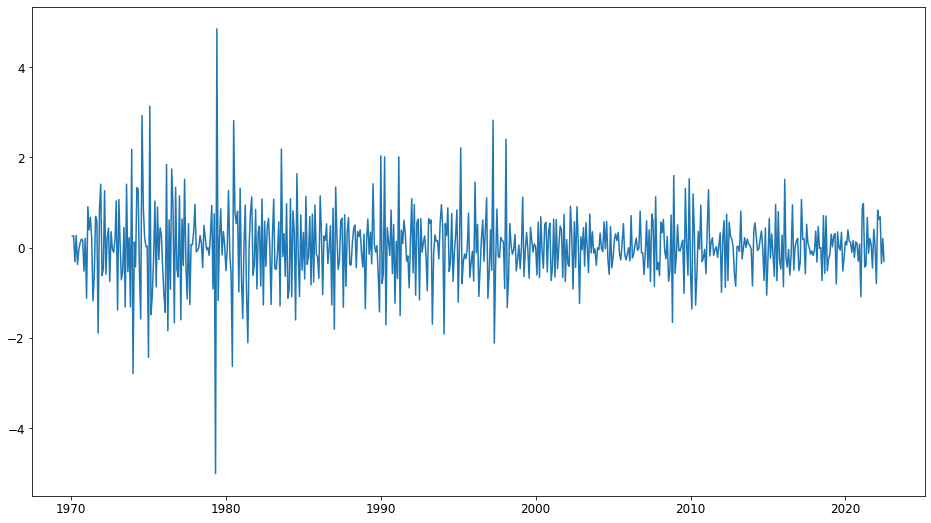

In [24]:
plt.plot(dif_alimentos)

from pyod.models.knn import KNN
knn = KNN(contamination=0.005, method='mean', n_neighbors=5)
knn.fit(np.array(dif_alimentos).reshape(-1,1))
predicted = pd.Series(knn.predict(np.array(dif_alimentos).reshape(-1,1)),index=dif_alimentos.index)
print('Number of outliers = ', predicted.sum())
outliers = predicted[predicted == 1]
outliers = dif_alimentos.loc[outliers.index]
outliers

def plot_outliers(outliers, data, method='KNN',halignment = 'right',valignment = 'top',labels=False):
    ax = data.plot(alpha=0.6)
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8,
                     markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}',
                     horizontalalignment=halignment,
                     verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX',markersize=9)
    plt.title(f'Serie alimentos - {method}')
    plt.xlabel('date'); plt.ylabel('')
    plt.legend(['Serie alimentos','outliers'])
    plt.show()

plot_outliers(outliers, dif_alimentos, 'KNN')

dif_alimentos2 = dif_alimentos[np.abs(dif_alimentos)<np.min(np.abs(outliers.values))]
plt.plot(dif_alimentos2)

In [25]:
df_alimentos = pd.DataFrame(dif_alimentos)
df1 = pd.DataFrame()

for i in range(12,0,-1):
    df1[['t-'+str(i)]] = df_alimentos.shift(i)

In [26]:
# Create column t
print(df1.shape)
df1['t'] = df_alimentos.values
df1 = df1.dropna()
print(df1.head())
print(df1.shape)

(630, 12)
                t-12      t-11      t-10       t-9       t-8       t-7  \
Fecha                                                                    
1971-02-01  0.257388  0.262088 -0.310265  0.269412 -0.370465 -0.053120   
1971-03-01  0.262088 -0.310265  0.269412 -0.370465 -0.053120  0.104468   
1971-04-01 -0.310265  0.269412 -0.370465 -0.053120  0.104468  0.190053   
1971-05-01  0.269412 -0.370465 -0.053120  0.104468  0.190053  0.169916   
1971-06-01 -0.370465 -0.053120  0.104468  0.190053  0.169916 -0.519476   

                 t-6       t-5       t-4       t-3       t-2       t-1  \
Fecha                                                                    
1971-02-01  0.104468  0.190053  0.169916 -0.519476  0.209212 -1.119209   
1971-03-01  0.190053  0.169916 -0.519476  0.209212 -1.119209  0.909997   
1971-04-01  0.169916 -0.519476  0.209212 -1.119209  0.909997  0.393731   
1971-05-01 -0.519476  0.209212 -1.119209  0.909997  0.393731  0.673333   
1971-06-01  0.209212 -1.119

In [27]:
#Entrenamiento, validacion y prueba
X1=df1.values[:, 0:-1] 
y1=df1.values[:, -1] 
print(X1[0])
print(X1.__class__)
print(len(y1))

[ 0.25738826  0.26208821 -0.31026491  0.26941226 -0.37046455 -0.05312029
  0.104468    0.19005304  0.16991645 -0.51947647  0.20921156 -1.11920864]
<class 'numpy.ndarray'>
618


In [28]:
traintarget_size = int(len(y1) * 0.85)   # Set split, este porcentaje tan raro es para que coincida con el del ejemplo de R.
y_trainF, y_test = y1[0:traintarget_size], y1[traintarget_size:len(y1)]

print('Observations for Target: %d' % (len(y1)))
print('Training Observations for Target: %d' % (len(y_trainF)))
print('Testing Observations for Target: %d' % (len(y_test)))

Observations for Target: 618
Training Observations for Target: 525
Testing Observations for Target: 93


In [29]:
trainfeature_size = int(len(X1) * 0.85)
X_trainF, X_test = X1[0:trainfeature_size], X1[trainfeature_size:len(X1)]   ##Regresoras
print('Observations for feature: %d' % (len(X1)))
print('Training Observations for feature: %d' % (len(X_trainF)))
print('Testing Observations for feature: %d' % (len(X_test)))

Observations for feature: 618
Training Observations for feature: 525
Testing Observations for feature: 93


In [30]:
traintarget_size = int(len(y_trainF) * 0.88)   # Set split, este porcentaje tan raro es para que coincida con el del ejemplo de R.
y_train, y_val = y_trainF[0:traintarget_size], y_trainF[traintarget_size:len(y_trainF)]

print('Observations for Target: %d' % (len(y_trainF)))
print('Training Observations for Target: %d' % (len(y_train)))
print('Testing Observations for Target: %d' % (len(y_val)))

Observations for Target: 525
Training Observations for Target: 462
Testing Observations for Target: 63


In [31]:
trainfeature_size = int(len(X_trainF) * 0.88)
X_train, X_val = X_trainF[0:trainfeature_size], X_trainF[trainfeature_size:len(X_trainF)]   ##Regresoras
print('Observations for feature: %d' % (len(X_trainF)))
print('Training Observations for feature: %d' % (len(X_train)))
print('Testing Observations for feature: %d' % (len(X_val)))

Observations for feature: 525
Training Observations for feature: 462
Testing Observations for feature: 63


In [32]:
X_trainF, X_test, y_trainF, y_test = train_test_split(X1,y1,test_size=0.15, train_size=0.85, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_trainF,y_trainF, test_size = 0.12, train_size = 0.88, shuffle=False)

In [33]:
print(X_train[0])
print(y_train[0])

[ 0.25738826  0.26208821 -0.31026491  0.26941226 -0.37046455 -0.05312029
  0.104468    0.19005304  0.16991645 -0.51947647  0.20921156 -1.11920864]
0.9099970802642576


In [34]:
# Decision Tree Regresion Model
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
DT_alimentos = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
DT_alimentos.fit(X_train, y_train)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",DT_alimentos.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de Validación:",DT_alimentos.score(X_val,y_val))  # predictions are horrible if negative value, no relationship if 0

print("el RECM es:",(((DT_alimentos.predict(X_val)-y_val)**2).sum())**0.5)
#print("el RECM sobre el conjunto de prueba es:",sklearn.metrics.mean_squared_error(DT_alimentos.predict(test_feature),test_target, squared=False))

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: -0.6007623898255494
el RECM es: 5.974631106486913


In [35]:
for d in [2, 3, 4, 5,6,7,8,9,10]:
    # Create the tree and fit it
    DT_alimentos = DecisionTreeRegressor(max_depth=d)
    DT_alimentos.fit(X_train, y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",DT_alimentos.score(X_train, y_train))
    print("Coeficiente R2 sobre el conjunto de Validación:",DT_alimentos.score(X_val, y_val), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de prueba es:",sklearn.metrics.mean_squared_error(DT_alimentos.predict(X_val),y_val, squared=False))

max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.21994873516904112
Coeficiente R2 sobre el conjunto de Validación: -0.09901815024678728 

el RECM sobre el conjunto de prueba es: 0.6237058498517105
max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.3086334958455915
Coeficiente R2 sobre el conjunto de Validación: -0.23101578285310276 

el RECM sobre el conjunto de prueba es: 0.6600991834208185
max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.37943842961407326
Coeficiente R2 sobre el conjunto de Validación: -0.10167236642419075 

el RECM sobre el conjunto de prueba es: 0.624458545269185
max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.45146272561412915
Coeficiente R2 sobre el conjunto de Validación: -0.06826598132995021 

el RECM sobre el conjunto de prueba es: 0.6149178276844256
max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.5136854457839175
Coeficiente R2 sobre el conjunto de Validación: 0.0377886765889

$\textit{max_depth}=8$ vemos una mejoría en el valor de ambos coeficientes, a pesar que a partir de $\textit{max_depth}=9$ en el conjunto de entrenamiento el $R2$ aumenta, en el conjunto de validación no ocurre lo mismo con el $R2$, además el RECM va en aumento, por tanto lo más optimo sería quedarse con $\textit{max_depth}=8$.

In [36]:
path=DT_alimentos.cost_complexity_pruning_path(X_train, y_train)
alphas=path['ccp_alphas']
print(alphas.shape)
print([alphas.min(), alphas.max()])
div=15

(122,)
[0.0, 0.10157400192889343]


In [37]:
accuracy_train,accuracy_test=[],[]
for i in alphas:
    tree=DecisionTreeRegressor(ccp_alpha=i)

    tree.fit(X_train, y_train)
    y_train_pred=tree.predict(X_train)
    y_test_pred=tree.predict(X_val)


    accuracy_train.append(sklearn.metrics.mean_squared_error(y_train_pred, y_train, squared=False))
    accuracy_test.append(sklearn.metrics.mean_squared_error(y_test_pred, y_val,squared=False))

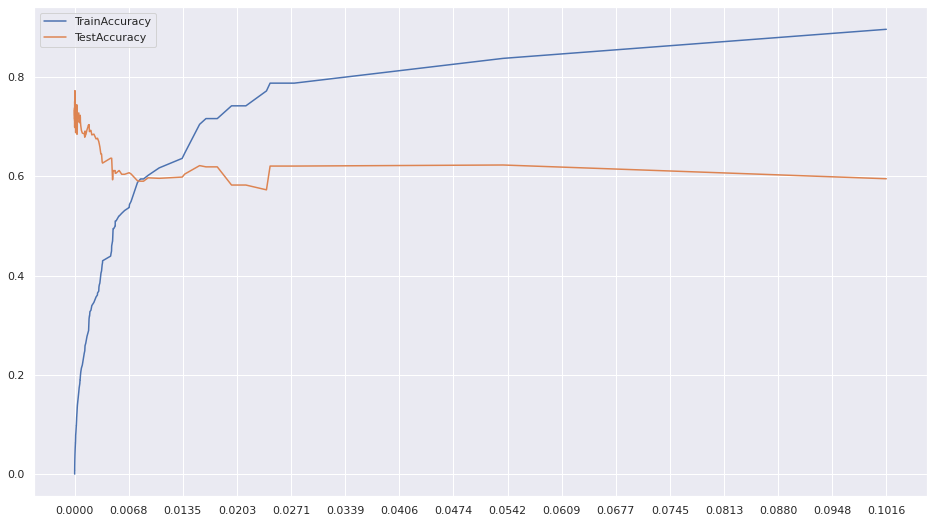

In [38]:
sns.set()
plt.figure(figsize=(16,9))

sns.lineplot(y=accuracy_train,x=alphas,label="TrainAccuracy")

sns.lineplot(y=accuracy_test,x=alphas,label="TestAccuracy")

plt.xticks(ticks=np.arange(0.00,alphas.max(),(alphas.max()-alphas.min())/div))
plt.show()

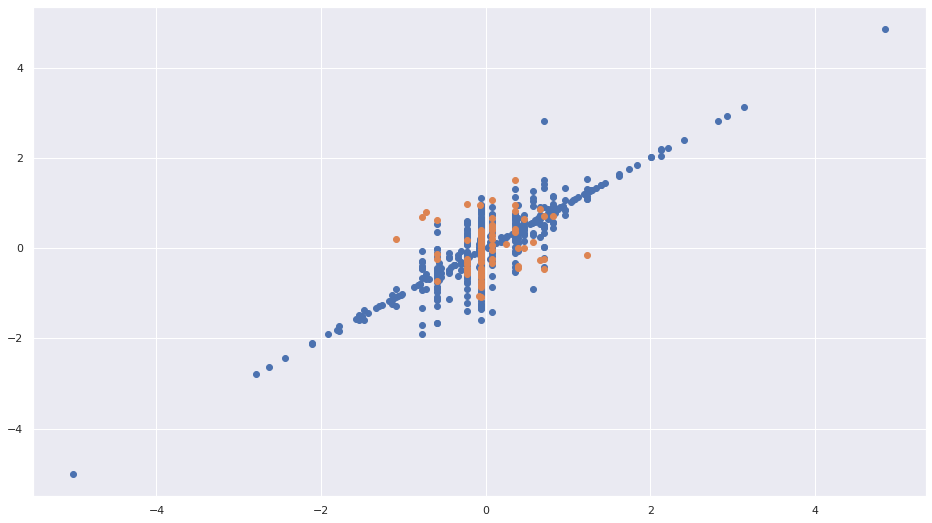

Raíz de la Pérdida cuadrática Entrenamiento: 0.43727407127563894
Raíz de la Pérdida cuadrática Prueba: 0.5623936583089382


In [39]:
####entrenamiento y validacion y_trainF.size
# Plot predicted against actual values

# Use the best max_depth 
DT_alimentos = DecisionTreeRegressor(max_depth=8)  # fill in best max depth here
DT_alimentos.fit(X_trainF, y_trainF)

# Predict values for train and test
train_prediction = DT_alimentos.predict(X_trainF)
test_prediction = DT_alimentos.predict(X_test)

# Scatter the predictions vs actual values
plt.scatter(train_prediction, y_trainF, label='train')  # blue
plt.scatter(test_prediction, y_test, label='test')  # orange
plt.show()

print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_prediction, y_trainF,squared=False))
print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, y_test,squared=False))

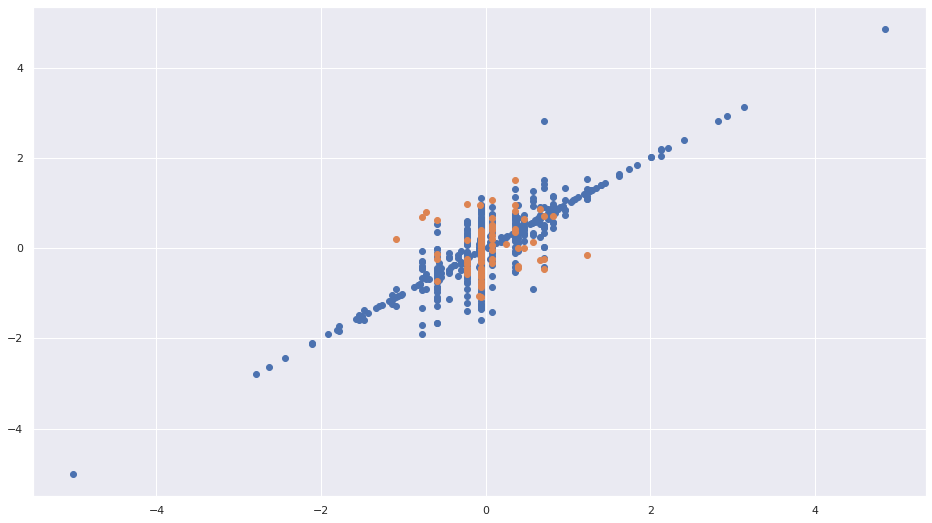

In [40]:
# Plot predicted against actual values

from matplotlib import pyplot as plt

# Use the best max_depth 
DT_alimentos_prun_mincost = DecisionTreeRegressor(ccp_alpha=0.0135)  # fill in best max depth here
#DT_alimentos_prun_mincost = DecisionTreeRegressor(ccp_alpha=0.01774)  # fill in best max depth here
DT_alimentos_prun_mincost.fit(X_trainF, y_trainF)

# Predict values for train and test
train_prediction_prun_mincost = DT_alimentos.predict(X_trainF)
test_prediction_prun_mincost = DT_alimentos.predict(X_test)

# Scatter the predictions vs actual values
plt.scatter(train_prediction_prun_mincost, y_trainF, label='train')  # blue
plt.scatter(test_prediction_prun_mincost, y_test, label='test')  # orange
plt.show()

|--- feature_11 <= -0.58
|   |--- feature_11 <= -2.27
|   |   |--- feature_4 <= 0.40
|   |   |   |--- feature_2 <= 0.68
|   |   |   |   |--- value: [4.85]
|   |   |   |--- feature_2 >  0.68
|   |   |   |   |--- feature_8 <= 0.75
|   |   |   |   |   |--- value: [3.14]
|   |   |   |   |--- feature_8 >  0.75
|   |   |   |   |   |--- value: [2.82]
|   |   |--- feature_4 >  0.40
|   |   |   |--- value: [0.13]
|   |--- feature_11 >  -2.27
|   |   |--- feature_10 <= 0.94
|   |   |   |--- feature_11 <= -1.28
|   |   |   |   |--- feature_5 <= 0.25
|   |   |   |   |   |--- feature_2 <= 0.07
|   |   |   |   |   |   |--- feature_8 <= -0.02
|   |   |   |   |   |   |   |--- feature_7 <= 0.12
|   |   |   |   |   |   |   |   |--- value: [1.19]
|   |   |   |   |   |   |   |--- feature_7 >  0.12
|   |   |   |   |   |   |   |   |--- value: [1.41]
|   |   |   |   |   |   |--- feature_8 >  -0.02
|   |   |   |   |   |   |   |--- value: [0.53]
|   |   |   |   |   |--- feature_2 >  0.07
|   |   |   |   |   | 

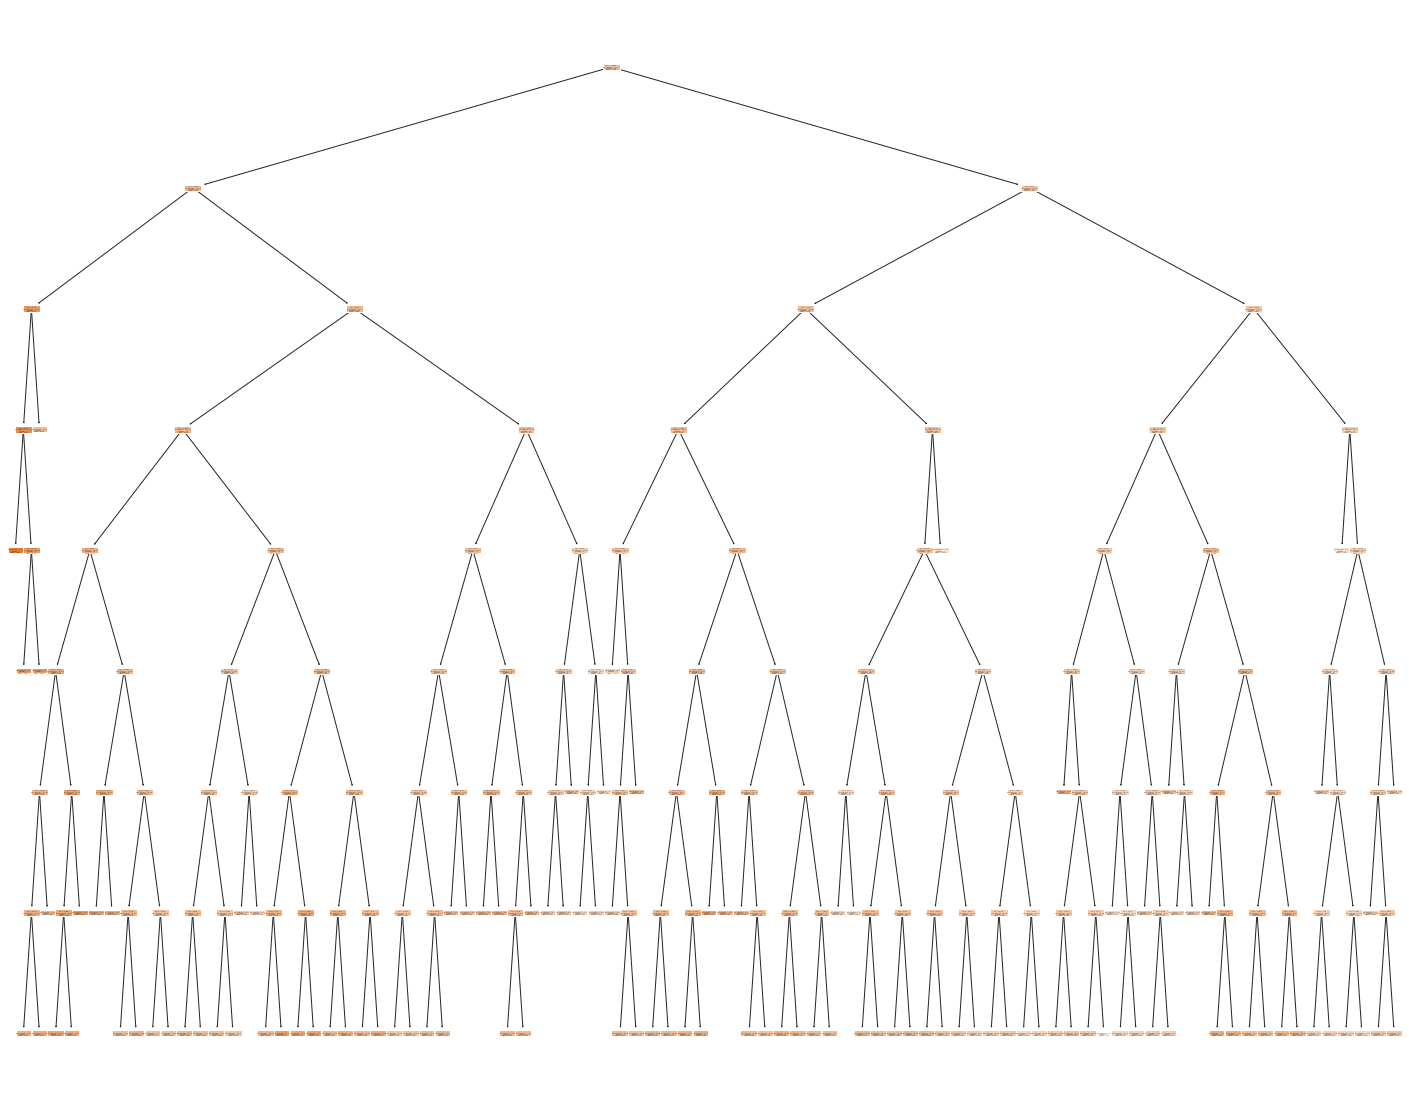

In [41]:
from sklearn import tree

listacaract=list(df1.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(DT_alimentos)
print(text_representation)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT_alimentos, feature_names=listacaract,  class_names=respuesta, filled=True) # el rezago más importante es el 11

In [42]:
print(train_prediction.size)
print(X_trainF.size)

print(test_prediction.size)
print(y_test.size)

525
6300
93
93


In [43]:
idx_test=df1.index
print(idx_test.size)  ###Tamaño del índice
indicetrain=idx_test[0:525]
indicetest=idx_test[525:618]

618


In [44]:
targetjoint=np.concatenate((y_trainF,y_test))
predictionjoint=np.concatenate((train_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

618
618


In [45]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=idx_test)
ObsvsPred.head()

,observado,Predicción
Fecha,,
1971-02-01,0.909997,0.654925
1971-03-01,0.393731,-0.223669
1971-04-01,0.673333,0.389252
1971-05-01,0.221323,-0.223669
1971-06-01,-1.180228,-0.055888


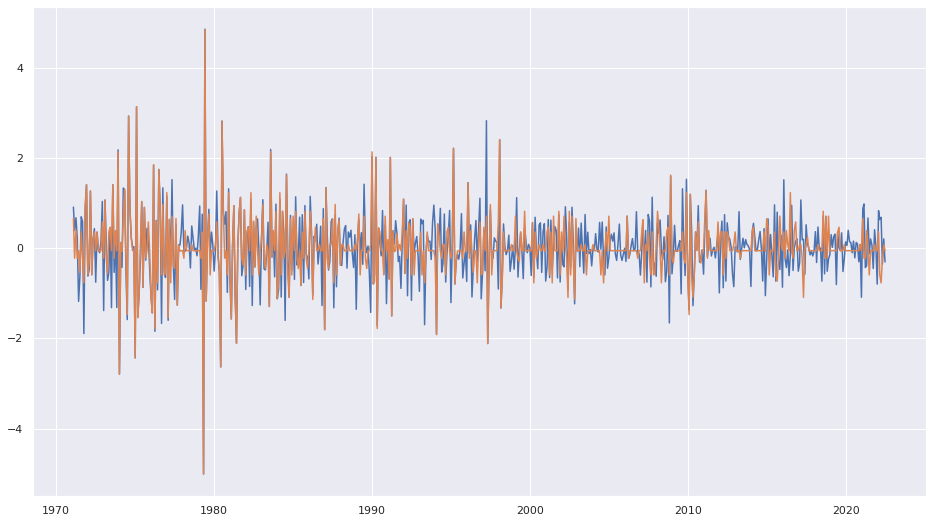

In [46]:
plt.plot(ObsvsPred)

In [47]:
import statistics as stats
stats.mean((ObsvsPred["observado"] - ObsvsPred["Predicción"])**2)

0.21003103291667297

#### Devolviendo a la escala original

In [48]:
bcAlimentos[13]

0.8058469287678538

In [49]:
print(ObsvsPred['observado'].head())
ObsvsPred['observado'] = np.insert(ObsvsPred['observado'].values[1:],0,bcAlimentos[13]) # reemplaza el elemento cero por bcAlimentos[13] (corresponde a 1971-02-01 )
print(ObsvsPred['observado'][0:5])
ObsvsPred['observado'] = np.cumsum(ObsvsPred['observado'].values) # función inversa de diff
print(ObsvsPred['observado'].head())
ObsvsPred['observado'] = sp.special.inv_boxcox(ObsvsPred['observado'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.head()

Fecha
1971-02-01    0.909997
1971-03-01    0.393731
1971-04-01    0.673333
1971-05-01    0.221323
1971-06-01   -1.180228
Freq: MS, Name: observado, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    0.393731
1971-04-01    0.673333
1971-05-01    0.221323
1971-06-01   -1.180228
Freq: MS, Name: observado, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    1.199578
1971-04-01    1.872911
1971-05-01    2.094235
1971-06-01    0.914006
Freq: MS, Name: observado, dtype: float64


,observado,Predicción
Fecha,,
1971-02-01,2.1,0.654925
1971-03-01,2.9,-0.223669
1971-04-01,4.8,0.389252
1971-05-01,5.6,-0.223669
1971-06-01,2.3,-0.055888


In [50]:
alimentos[13:18]

Fecha
1971-02-01    2.1
1971-03-01    2.9
1971-04-01    4.8
1971-05-01    5.6
1971-06-01    2.3
Freq: MS, Name: alimentos, dtype: float64

In [51]:
print(ObsvsPred['Predicción'].head())
ObsvsPred['Predicción'] = np.insert(ObsvsPred['Predicción'].values[1:],0,bcAlimentos[13]) # reemplaza el elemento cero por bcAlimentos[13] (corresponde a 1971-02-01 )
print(ObsvsPred['Predicción'][0:5])
ObsvsPred['Predicción'] = np.cumsum(ObsvsPred['Predicción'].values) # función inversa de diff
print(ObsvsPred['Predicción'].head())
ObsvsPred['Predicción'] = sp.special.inv_boxcox(ObsvsPred['Predicción'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.tail()

Fecha
1971-02-01    0.654925
1971-03-01   -0.223669
1971-04-01    0.389252
1971-05-01   -0.223669
1971-06-01   -0.055888
Freq: MS, Name: Predicción, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01   -0.223669
1971-04-01    0.389252
1971-05-01   -0.223669
1971-06-01   -0.055888
Freq: MS, Name: Predicción, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    0.582178
1971-04-01    0.971430
1971-05-01    0.747761
1971-06-01    0.691874
Freq: MS, Name: Predicción, dtype: float64


,observado,Predicción
Fecha,,
2022-03-01,261.8,353.018961
2022-04-01,318.7,284.165606
2022-05-01,288.0,266.257878
2022-06-01,305.5,272.486274
2022-07-01,279.9,268.073383


In [52]:
alimentos[-5:]

Fecha
2022-03-01    261.8
2022-04-01    318.7
2022-05-01    288.0
2022-06-01    305.5
2022-07-01    279.9
Freq: MS, Name: alimentos, dtype: float64

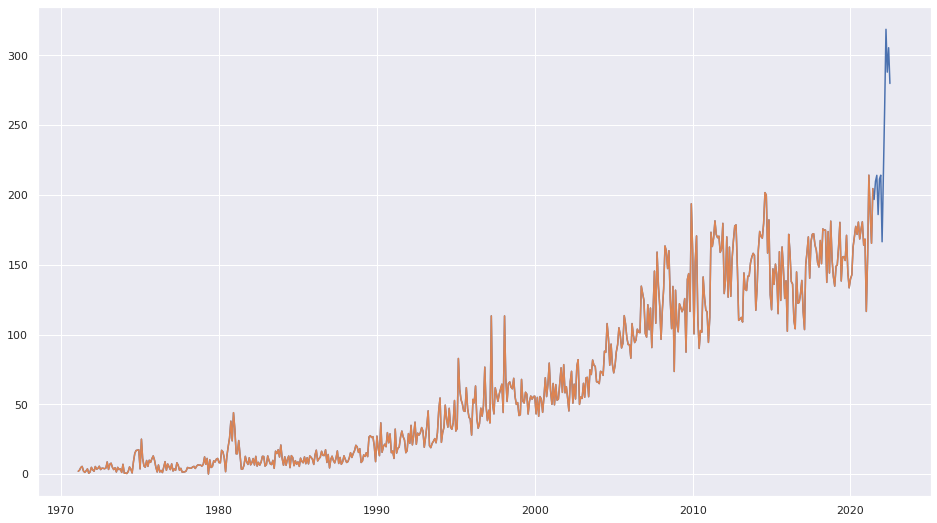

In [53]:
# chequeo que la inversa si arroja la serie original
d1 = {'observado': ObsvsPred['observado'], 'Predicción': alimentos.iloc[0:618]}
ObsvsPred1=pd.DataFrame(data=d1,index=idx_test)
plt.plot(ObsvsPred1)

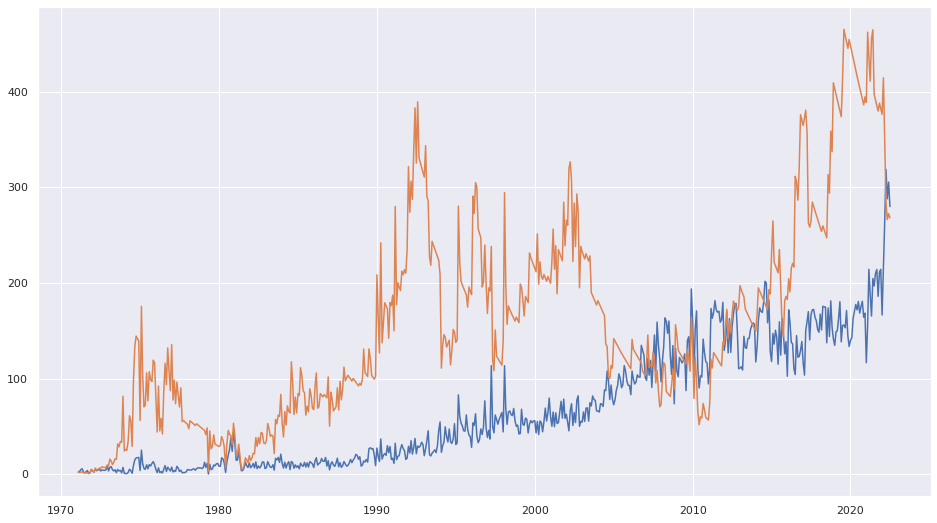

In [54]:
plt.plot(ObsvsPred)

In [55]:
## Error cuadratico medio de predicción árbol de decisión
import statistics as stats
stats.mean((ObsvsPred["observado"] - ObsvsPred["Predicción"])**2)

15405.696358749852

#### Bagging

In [56]:
from sklearn.ensemble import  BaggingRegressor # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
bag_rgr =  BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_rgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_samples=100,
                 n_estimators=500, n_jobs=-1)

In [57]:
# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",bag_rgr.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de Validación:",bag_rgr.score(X_val,y_val))  # predictions are horrible if negative value, no relationship if 0

print("el RECM es:",(((bag_rgr.predict(X_val)-y_val)**2).sum())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 0.4835023064279338
Coeficiente R2 sobre el conjunto de Validación: 0.16259569139706187
el RECM es: 4.32130833450427


In [58]:
# Predict values for train and test
bag_rgr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_rgr.fit(X_trainF, y_trainF)

train_prediction = bag_rgr.predict(X_trainF)
test_prediction = bag_rgr.predict(X_test)

In [59]:
targetjoint=np.concatenate((y_trainF,y_test))
predictionjoint=np.concatenate((train_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

618
618


In [60]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=idx_test)
ObsvsPred.head()

,observado,Predicción
Fecha,,
1971-02-01,0.909997,0.551450
1971-03-01,0.393731,-0.206461
1971-04-01,0.673333,-0.167314
1971-05-01,0.221323,-0.398057
1971-06-01,-1.180228,-0.362536


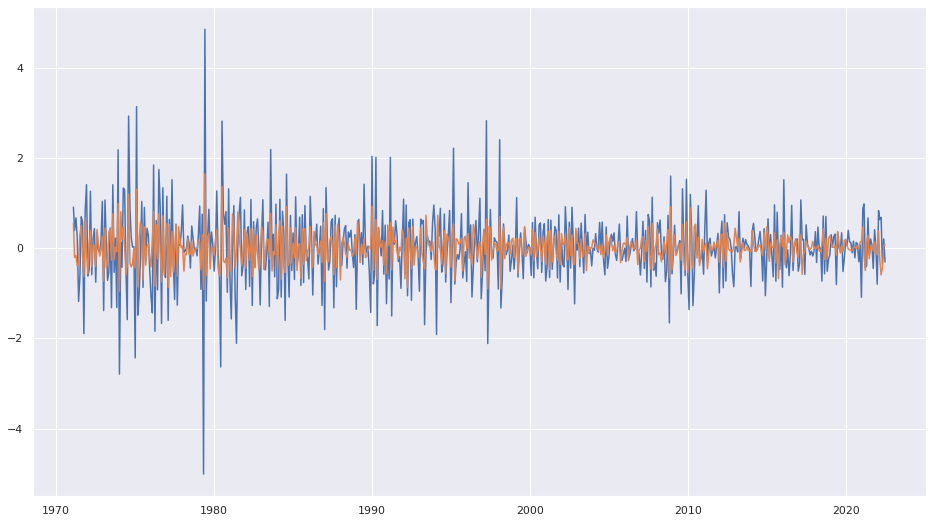

In [61]:
plt.plot(ObsvsPred)

In [62]:
print(ObsvsPred['observado'].head())
ObsvsPred['observado'] = np.insert(ObsvsPred['observado'].values[1:],0,bcAlimentos[13]) # reemplaza el elemento cero por bcAlimentos[13] (corresponde a 1971-02-01 )
print(ObsvsPred['observado'][0:5])
ObsvsPred['observado'] = np.cumsum(ObsvsPred['observado'].values) # función inversa de diff
print(ObsvsPred['observado'].head())
ObsvsPred['observado'] = sp.special.inv_boxcox(ObsvsPred['observado'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.head()

Fecha
1971-02-01    0.909997
1971-03-01    0.393731
1971-04-01    0.673333
1971-05-01    0.221323
1971-06-01   -1.180228
Freq: MS, Name: observado, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    0.393731
1971-04-01    0.673333
1971-05-01    0.221323
1971-06-01   -1.180228
Freq: MS, Name: observado, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    1.199578
1971-04-01    1.872911
1971-05-01    2.094235
1971-06-01    0.914006
Freq: MS, Name: observado, dtype: float64


,observado,Predicción
Fecha,,
1971-02-01,2.1,0.551450
1971-03-01,2.9,-0.206461
1971-04-01,4.8,-0.167314
1971-05-01,5.6,-0.398057
1971-06-01,2.3,-0.362536


In [63]:
print(ObsvsPred['Predicción'].head())
ObsvsPred['Predicción'] = np.insert(ObsvsPred['Predicción'].values[1:],0,bcAlimentos[13]) # reemplaza el elemento cero por bcAlimentos[13] (corresponde a 1971-02-01 )
print(ObsvsPred['Predicción'][0:5])
ObsvsPred['Predicción'] = np.cumsum(ObsvsPred['Predicción'].values) # función inversa de diff
print(ObsvsPred['Predicción'].head())
ObsvsPred['Predicción'] = sp.special.inv_boxcox(ObsvsPred['Predicción'].values, lambdaest) # inversa de Box-Cox
ObsvsPred.tail()

Fecha
1971-02-01    0.551450
1971-03-01   -0.206461
1971-04-01   -0.167314
1971-05-01   -0.398057
1971-06-01   -0.362536
Freq: MS, Name: Predicción, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01   -0.206461
1971-04-01   -0.167314
1971-05-01   -0.398057
1971-06-01   -0.362536
Freq: MS, Name: Predicción, dtype: float64
Fecha
1971-02-01    0.805847
1971-03-01    0.599386
1971-04-01    0.432072
1971-05-01    0.034015
1971-06-01   -0.328521
Freq: MS, Name: Predicción, dtype: float64


,observado,Predicción
Fecha,,
2022-03-01,261.8,175.865888
2022-04-01,318.7,144.732483
2022-05-01,288.0,125.100740
2022-06-01,305.5,128.086744
2022-07-01,279.9,131.361707


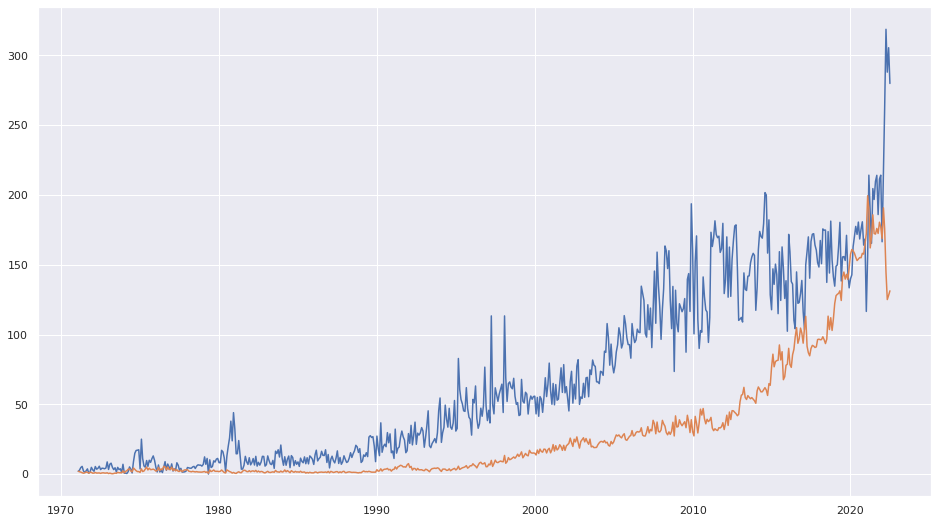

In [64]:
plt.plot(ObsvsPred)

In [65]:
y_pred = bag_rgr.predict(X_test)

In [66]:
stats.mean((y_test - y_pred)**2)

0.21605002751091326

In [ ]:
y_pred2 = np.insert(y_pred[1:],0,bcAlimentos[-93])  # [0:-1] remueve la predicción del último
y_pred2 = np.cumsum(y_pred2) # función inversa de diff
y_pred2 = sp.special.inv_boxcox(y_pred2, lambdaest) # inversa de Box-Cox
y_pred2[0:5]

In [ ]:
y_test2 = np.insert(y_test[1:],0,bcAlimentos[-93])  # [0:-1] remueve la predicción del último
y_test2 = np.cumsum(y_test2) # función inversa de diff
y_test2 = sp.special.inv_boxcox(y_test2, lambdaest) # inversa de Box-Cox
y_test2[0:5]

In [ ]:
stats.mean((y_test2 - y_pred2)**2)

### Redes neuronales (multicapa MLN o redes recurrentes RNN)

En el caso de redes neuronales o redes neuronales recurrentes, el modelo debe tener una sola capa oculta con 8, 16 o 32 neuronas en la capa oculta y con función de activación tanh o ReLU(el tamaño del lote debe ser igual al tamaño del conjunto de entrenamiento, el algoritmo de optimización que usted crea conveniente, al igual que la tasa de aprendizaje, y número de epochs=50)

### Modelos SARIMA

## Error Cuadrático Medio

Obtenga el error cuadrático medio de predicción un paso adelante basado en los modelos ajustados del punto anterior y el conjunto de prueba. Cuál modelo escogería basado en éste criterio únicamente?